In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os, sys
import datetime
from datetime import date
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
#%matplotlib inline

# Initial directories set up
dirname = os.path.dirname(os.path.abspath('__file__'))
datadir = os.path.join(os.path.abspath(os.path.join(os.path.join(dirname, os.pardir), os.pardir)), 'data/')

"""
Need to create a big dataframe. For each csv file we should add the data to the dataframe,
check if the column names coincide and expand the dataframe.

Loop through all folders, and add a column to each project that represents the year
and the season of the year.
"""
data = pd.read_csv(os.path.join(datadir, "2016-05-15T020446/Kickstarter001.csv"))

#First lets drop the columns that have no values
to_drop = ['friends','is_starred','is_backing','permissions']
data.drop(to_drop, inplace=True, axis=1)
#Now we will drop the columns/variables that we have determine have no value to our study
to_drop2 = ['photo','staff_pick','currency_symbol','currency_trailing_code',
           'slug','disable_communication','creator','spotlight','profile','urls','source_url']
data.drop(to_drop2, inplace=True, axis=1)

#Here is were you upload the merged data  
# data = pd.read_pickle(os.path.join(datadir, 'dataframe_total.pkl'))
# f = open(os.path.join(datadir, 'dataframe_total.pkl'), 'rb')

id                  0
name                0
blurb               2
goal                0
pledged             0
state               0
country             0
currency            0
deadline            0
state_changed_at    0
created_at          0
launched_at         0
backers_count       0
static_usd_rate     0
usd_pledged         0
location            1
category            0
dtype: int64
(4435, 17)
id                     4435
name                   4432
state                     5
country                  18
currency                 10
backers_count           496
usd_pledged            2783
location               1598
category                 18
usd_goal               1366
duration               1196
days_until_launched    4425
year_launched             8
month_launched           12
weekday_launched          7
name_length              14
description_length       31
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4435 entries, 0 to 4437
Data columns (total 17 columns):
id    

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:157: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


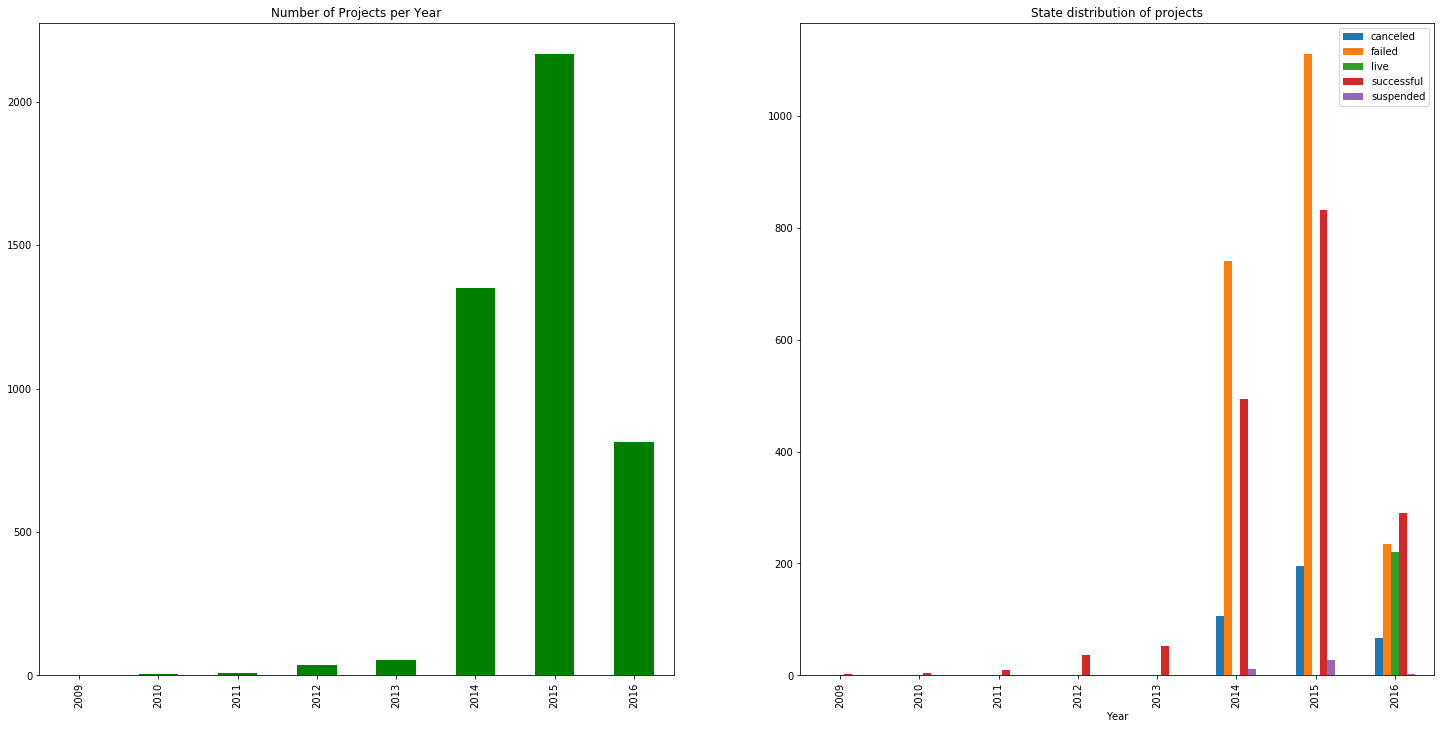

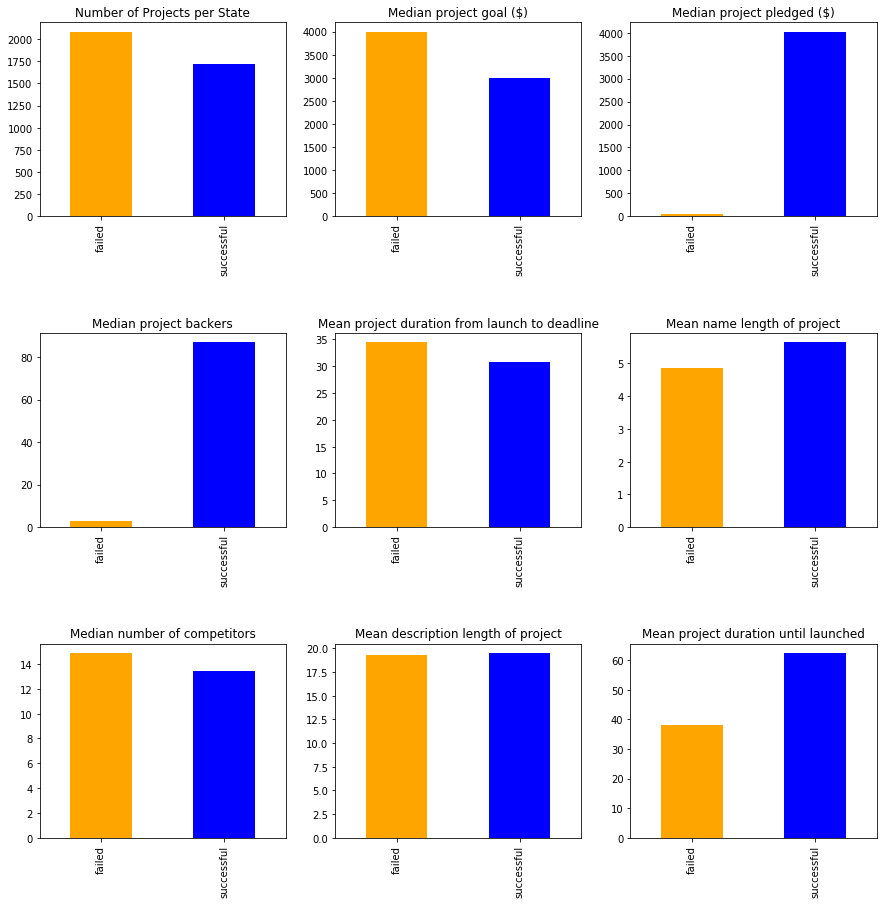

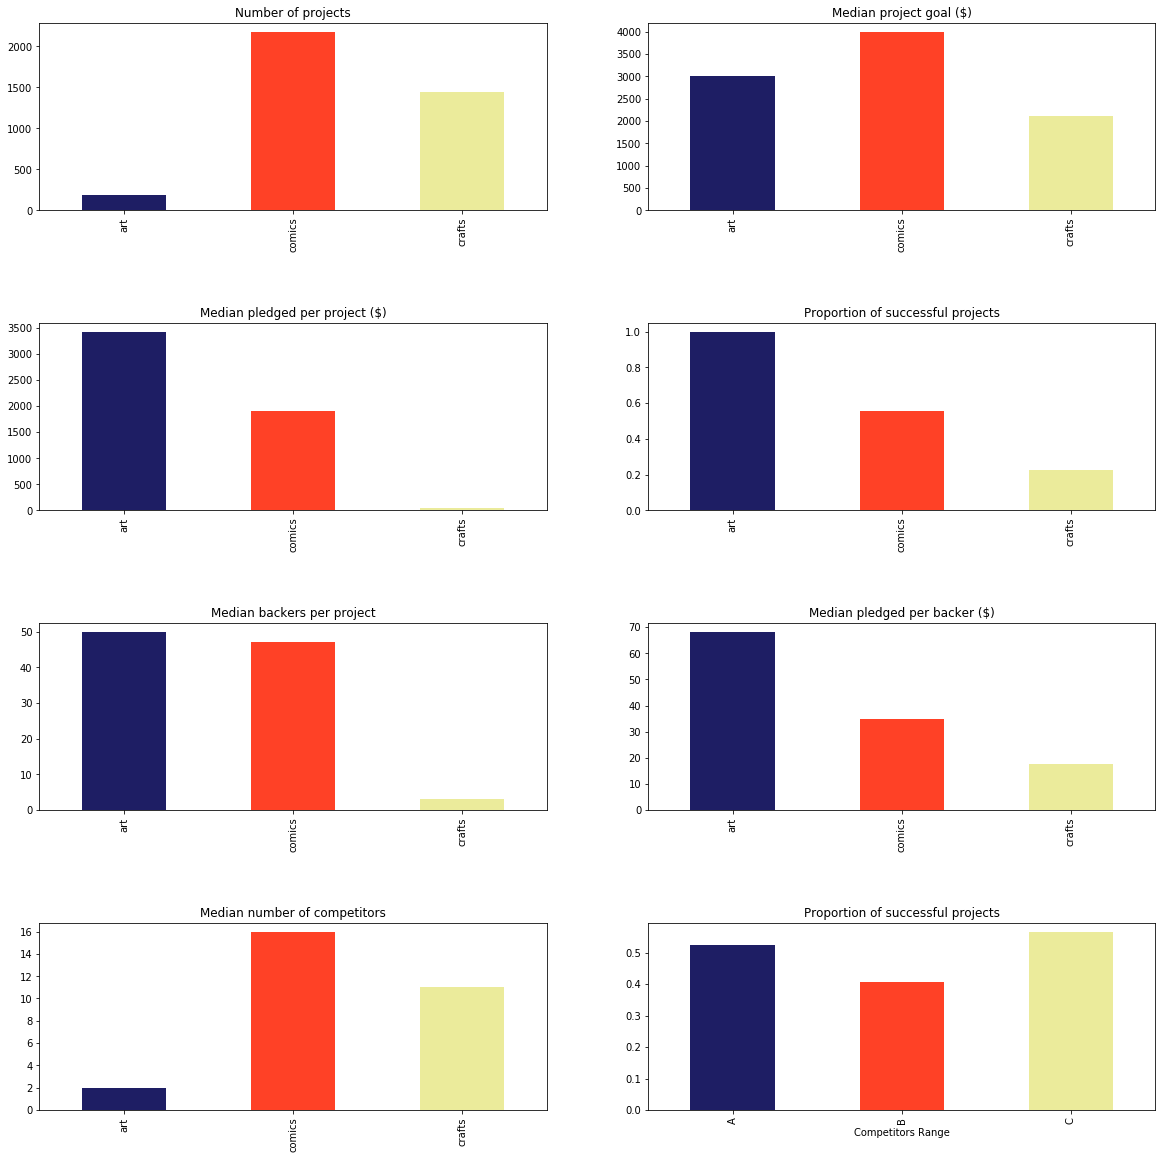

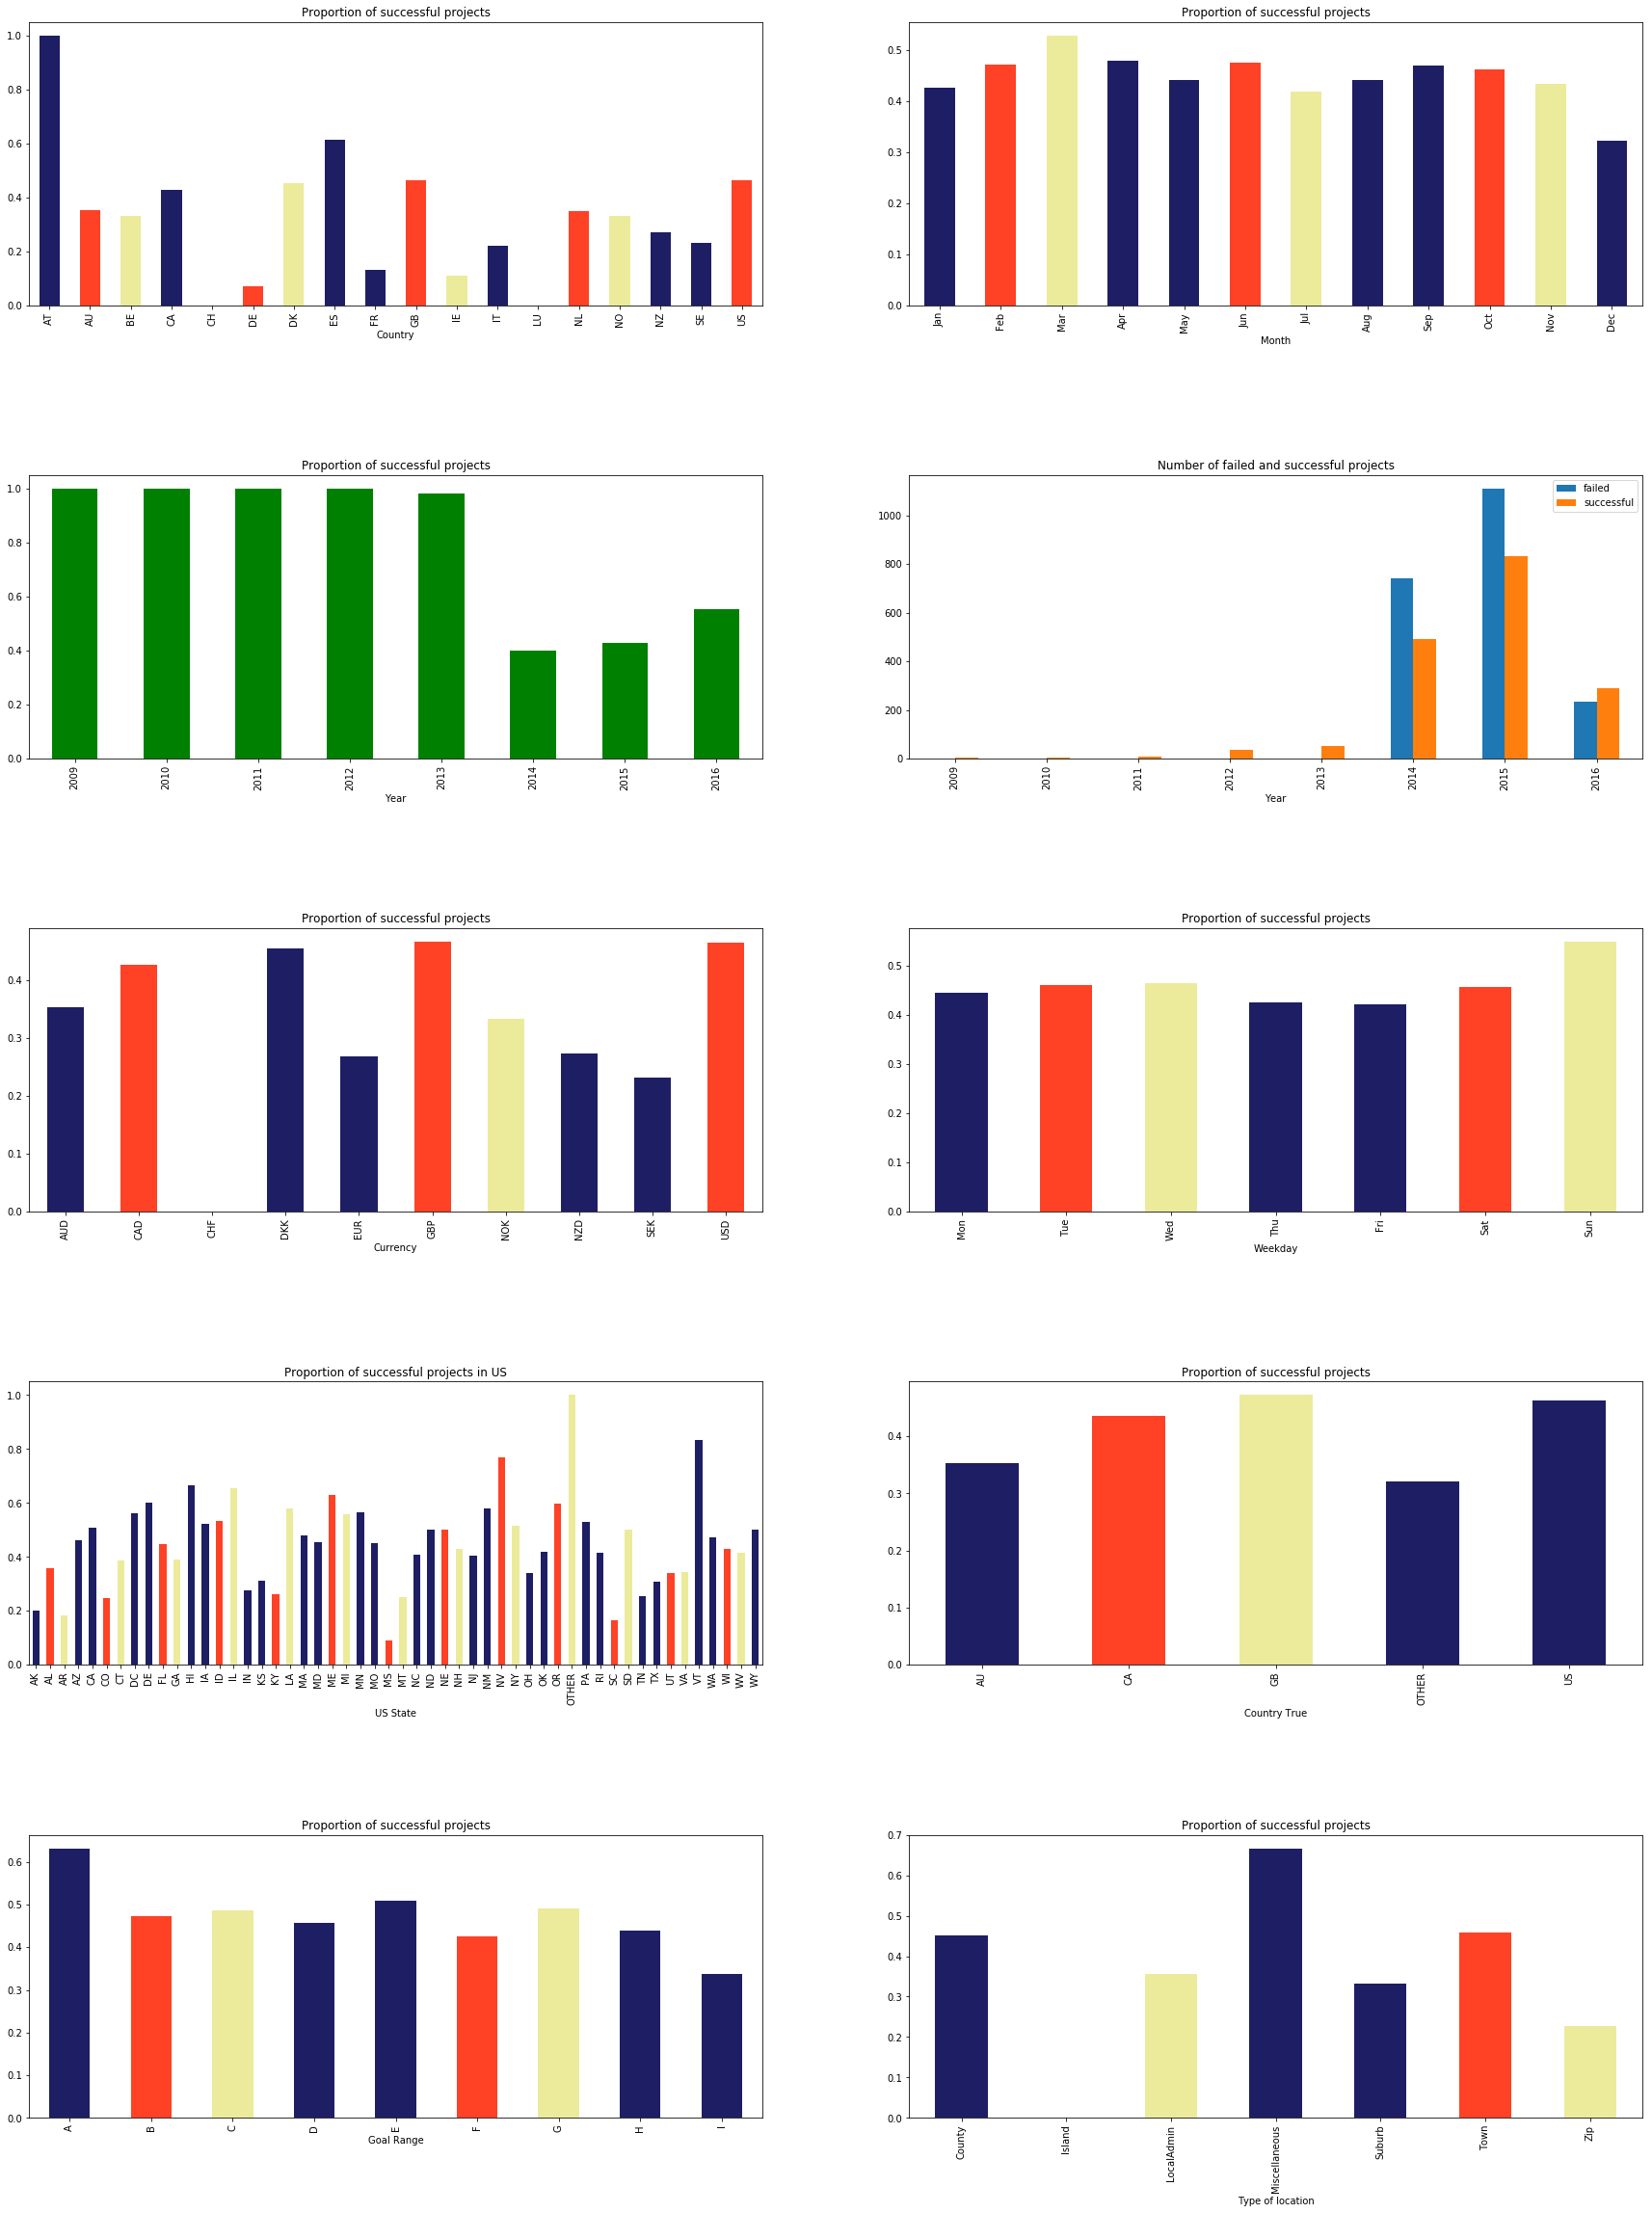

In [2]:
#Look for missing values
print(data.isna().sum()) 
#The amount of missing values is low, really low percentage, so we can drop them.
data = data.dropna()

#Create usd_goal, where we convert the goal into usd
data["usd_goal"] = data["goal"]*data["static_usd_rate"]
#Drop the original goal feature
data.drop("goal", inplace=True, axis=1)
   
#Create variable duration in days between the launching date and the deadline. 
#We get a variable in seconds
data["duration"] = data["deadline"]-data["launched_at"]
#Transform the variable to days
data["duration"] = data["duration"]/(60*60*24)

#Create variable duration in days between the created at date and the launching date. 
#We get a variable in seconds
data["days_until_launched"] = data["launched_at"]-data["created_at"]
#Transform the variable to days
data["days_until_launched"] = data["days_until_launched"]/(60*60*24)

#Create the variables Month and Year in which the project was launched
#day=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(1347517370))  

data['year_launched'] = data.apply(lambda row: time.strftime('%Y', time.localtime(row.launched_at)), axis=1)
data['month_launched'] = data.apply(lambda row: time.strftime('%b', time.localtime(row.launched_at)), axis=1)
data['weekday_launched'] = data.apply(lambda row: time.strftime('%a', time.localtime(row.launched_at)), axis=1)
data['launched_at'] = data.apply(lambda row: datetime.datetime.fromtimestamp(row.launched_at), axis=1)
data['deadline'] = data.apply(lambda row: datetime.datetime.fromtimestamp(row.deadline), axis=1)

#Plot the amount of projects per year
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25,12))
data.groupby('year_launched').year_launched.count().plot(kind='bar', ax=ax1, color='green')
ax1.set_title('Number of Projects per Year')
ax1.set_xlabel('')

stateDistYear1 = pd.get_dummies(data.set_index('year_launched').state).groupby('year_launched').sum()
#stateDistYear1.columns = ['failed', 'successful']

stateDistYear1.plot(kind='bar', ax=ax2)
ax2.set_title('State distribution of projects')
ax2.set_xlabel('Year')

#Find out the length of the name, the amount of words used
data['name_length'] = data['name'].str.split().str.len()
#We get the length of the blurb variable too. It is the description   
data['description_length'] = data['blurb'].str.split().str.len() 

#Drop variables that we dont need anymore. Because they have been used to engineer new ones.
to_drop3 = ['blurb','state_changed_at','pledged','deadline','launched_at','created_at','static_usd_rate']
data.drop(to_drop3, inplace=True, axis=1)

#Lets look at the data. Printing summary of the kickstarter data not discarded
print(data.shape)
#This are the unique values across all columns. To determine which can be categorical variables.
print(data.nunique())
unique=data.nunique()
#Find out the columns data types
print(data.info())
datatypes=data.info()
#Summary of the information of each column
print(data.describe())
summary=data.describe()

# Create new columns main_category and sub_category on the new Data Frame data2
data['main_category'] = data['category'].apply(lambda x: x.split("slug",1)[-1].split("\"")[2].split("/")[0])
#data['sub_category'] = data['category'].apply(lambda x: x.split("slug",1)[-1].split("\"")[2].split("/")[-1])
# We drop the category variable since we don't need it anymore.
data.drop("category", inplace=True, axis=1)

#We extract the city, state and country from the location dictionary.
data['country2'] = data['location'].apply(lambda x: x.split("country",1)[-1].split("\"")[2])
data['region_state'] = data['location'].apply(lambda x: x.split("state",1)[-1].split("\"")[2])
data['type'] = data['location'].apply(lambda x: x.split("type",1)[-1].split("\"")[2])

data.loc[data['country2'] == 'short_name', 'country2'] = 'US'
# We drop the location variable since we don't need it anymore.
data.drop("location", inplace=True, axis=1)

#We calculate the pledge per backer for each project
data['pledge_per_backer']=data['usd_pledged']/data['backers_count']

#Calculate the percentage of "success" by dividing the amount of money pledge by the goal
data['success_rate']=data['usd_pledged']/data['usd_goal']*100

#There are no missing values in the data frame except for the pledge_per_backer
#variable. It is nan when both usd_pledged and backers are 0.
print(data.isna().sum()) 
#We fill all nan with zero
data.fillna(0,inplace=True)
print(data.isna().sum()) #Now there are no missing values

#We create a variable to evaluate the proportion of succesful projects depending
#on the goal money range
data.loc[data['usd_goal'] < 250,'goal_range'] = 'A'
data.loc[(data['usd_goal'] >= 250)&(data['usd_goal'] < 500),'goal_range'] = 'B'
data.loc[(data['usd_goal'] >= 500)&(data['usd_goal'] < 1000),'goal_range'] = 'C'
data.loc[(data['usd_goal'] >= 1000)&(data['usd_goal'] < 2000),'goal_range'] = 'D'
data.loc[(data['usd_goal'] >= 2000)&(data['usd_goal'] < 4000),'goal_range'] = 'E'
data.loc[(data['usd_goal'] >= 4000)&(data['usd_goal'] < 6000),'goal_range'] = 'F'
data.loc[(data['usd_goal'] >= 6000)&(data['usd_goal'] < 8000),'goal_range'] = 'G'
data.loc[(data['usd_goal'] >= 8000)&(data['usd_goal'] < 10000),'goal_range'] = 'H'
data.loc[data['usd_goal'] >= 10000,'goal_range'] = 'I'

#Calculate the number of competitors in the same category, with the same goal range and in a time perios
#same year and month
competitors=data.groupby(['main_category','year_launched','month_launched','goal_range']).count()
competitors=competitors[['name']]
competitors.reset_index(inplace=True)

#renaming columns of the derived table
colmuns_month=['main_category', 'year_launched', 'month_launched', 'goal_range', 'competitors']
competitors.columns=colmuns_month

#merging the particpants column into the base table
data = pd.merge(data, competitors, on = ['main_category', 'year_launched', 'month_launched','goal_range'], how = 'left')

#We create a variable to evaluate the proportion of succesful projects depending
#on the competitors range
data.loc[data['competitors'] < 10,'comp_range'] = 'A'
data.loc[(data['competitors'] >= 10)&(data['competitors'] < 30),'comp_range'] = 'B'
data.loc[(data['competitors'] >= 30)&(data['competitors'] < 60),'comp_range'] = 'C'
data.loc[(data['competitors'] >= 60)&(data['competitors'] < 100),'comp_range'] = 'D'
data.loc[(data['competitors'] >= 100)&(data['competitors'] < 150),'comp_range'] = 'E'
data.loc[(data['competitors'] >= 150)&(data['competitors'] < 200),'comp_range'] = 'F'
data.loc[data['competitors'] >= 200,'comp_range'] = 'G'

#We find out the distribution of data across state. 
percentage_per_state = round(data["state"].value_counts() / len(data["state"]) * 100,2)
print("State Percent: ")
print(percentage_per_state)
#The higher percentage belong to succesful and failed state, so we can get rid of the rest of the projects that have another category
#We only keep those projects that have values either successful or failed
data2 = data[(data['state'] == 'failed') | (data['state'] == 'successful')]

#Count the number of projects from each country and change the country of those that have less than 16,
#since it is a low amount to predict correctly, to OTHER
countryCount=data2.groupby('country2').country2.count()
countryCount=countryCount.sort_values()
countries=countryCount[countryCount < 51]
countries=list(countries.index.values)
data2.loc[data2['country2'].isin(countries),'country2'] = 'OTHER'


#data2 = data2[~data2['country2'].isin(countries)]
countryCount2=data2.groupby('country2').country2.count()
countryCount2=countryCount2.sort_values()

#Check if the data frame is in appropriate format:
data2.head()

#Finally, we drop the id variable. We dont need it for the models
#data2.drop("id", inplace=True, axis=1)

#Lets get a dataframe only with the projects in the US
dataUS=data2[data['country2'] == 'US']
#Percentage of projects that are from the US
USprojectPer=len(dataUS.index)/len(data2.index)*100

#State analysis. There is a small percentage with a wrong classification. Classify as OTHER
stateCount=dataUS.groupby('region_state').region_state.count()
dataUS.loc[dataUS['region_state']=='Canton of Basel-Country','region_state'] = 'OTHER'
dataUS.loc[dataUS['region_state']=='location','region_state'] = 'OTHER'
dataUS.loc[dataUS['region_state']=='short_name','region_state'] = 'OTHER'
dataUS.loc[dataUS['region_state']=='slug','region_state'] = 'OTHER'


#Calculating the distribution of projects across the main categories
stateDistCat = pd.get_dummies(data2.set_index('main_category').state).groupby('main_category').sum()
stateDistCat.columns = ['failed', 'successful']
#Finding the correlation of continuous variables with the dependent variable
corr=data2[['backers_count','usd_pledged','usd_goal','duration','name_length','days_until_launched','pledge_per_backer','state']].corr()

# Plotting

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15,15))
color=['orange', 'blue', 'pink', 'red', 'green', 'yellow', 'cyan']
color2 = cm.CMRmap(np.linspace(0.1,0.9,data2.main_category.nunique()))

data2.groupby('state').state.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of Projects per State')
ax1.set_xlabel('')

data2.groupby('state').usd_goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

data2.groupby('state').usd_pledged.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median project pledged ($)')
ax3.set_xlabel('')

data2.groupby('state').backers_count.median().plot(kind='bar', ax=ax4, color=color)
ax4.set_title('Median project backers')
ax4.set_xlabel('')

data2.groupby('state').duration.mean().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Mean project duration from launch to deadline')
ax5.set_xlabel('')

data2.groupby('state').name_length.mean().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Mean name length of project')
ax6.set_xlabel('')

#staffPickDistr = pd.get_dummies(data2.set_index('state').staff_pick).groupby('state').sum()
#staffPickDistr.columns = ['false', 'true']
#staffPickDistr.div(staffPickDistr.sum(axis=1), axis=0).true.plot(kind='bar', ax=ax7)
#ax7.set_title('Proportion that are staff picks')
#ax7.set_xlabel('')

data2.groupby('state').competitors.mean().plot(kind='bar', ax=ax7, color=color)
ax7.set_title('Median number of competitors')
ax7.set_xlabel('')

data2.groupby('state').description_length.mean().plot(kind='bar', ax=ax8, color=color)
ax8.set_title('Mean description length of project')
ax8.set_xlabel('')

data2.groupby('state').days_until_launched.mean().plot(kind='bar', ax=ax9, color=color)
ax9.set_title('Mean project duration until launched')
ax9.set_xlabel('')

fig.subplots_adjust(hspace=0.6)
plt.show()


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2, figsize=(20,20))

data2.groupby('main_category').main_category.count().plot(kind='bar', ax=ax1, color=color2)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

data2.groupby('main_category').usd_goal.median().plot(kind='bar', ax=ax2, color=color2)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

data2.groupby('main_category').usd_pledged.median().plot(kind='bar', ax=ax3, color=color2)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

stateDistCat.div(stateDistCat.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color2)
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

data2.groupby('main_category').backers_count.median().plot(kind='bar', ax=ax5, color=color2)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

data2.groupby('main_category').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color2)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

data2.groupby('main_category').competitors.median().plot(kind='bar', ax=ax7, color=color2)
ax7.set_title('Median number of competitors')
ax7.set_xlabel('')

stateDistComp = pd.get_dummies(data2.set_index('comp_range').state).groupby('comp_range').sum()
stateDistComp.columns = ['failed', 'successful']

stateDistComp.div(stateDistComp.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax8, color=color2)
ax8.set_title('Proportion of successful projects')
ax8.set_xlabel('Competitors Range')

fig.subplots_adjust(hspace=0.6)
plt.show()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(30,40))

stateDistCountry = pd.get_dummies(data2.set_index('country').state).groupby('country').sum()
stateDistCountry.columns = ['failed', 'successful']

stateDistCountry.div(stateDistCountry.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax1, color=color2)
ax1.set_title('Proportion of successful projects')
ax1.set_xlabel('Country')

stateDistMonth = pd.get_dummies(data2.set_index('month_launched').state).groupby('month_launched').sum()
stateDistMonth.columns = ['failed', 'successful']
stateDistMonth.index = stateDistMonth.index.str.strip()
stateDistMonth = stateDistMonth.reindex(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

stateDistMonth.div(stateDistMonth.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax2, color=color2)
ax2.set_title('Proportion of successful projects')
ax2.set_xlabel('Month')

stateDistYear = pd.get_dummies(data2.set_index('year_launched').state).groupby('year_launched').sum()
stateDistYear.columns = ['failed', 'successful']

stateDistYear.div(stateDistYear.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax3, color='green')
ax3.set_title('Proportion of successful projects')
ax3.set_xlabel('Year')

stateDistYear.plot(kind='bar', ax=ax4)
ax4.set_title('Number of failed and successful projects')
ax4.set_xlabel('Year')

stateDistCurr = pd.get_dummies(data2.set_index('currency').state).groupby('currency').sum()
stateDistCurr.columns = ['failed', 'successful']

stateDistCurr.div(stateDistCurr.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax5, color=color2)
ax5.set_title('Proportion of successful projects')
ax5.set_xlabel('Currency')

stateDistWeekday = pd.get_dummies(data2.set_index('weekday_launched').state).groupby('weekday_launched').sum()
stateDistWeekday.columns = ['failed', 'successful']
stateDistWeekday.index = stateDistWeekday.index.str.strip()
stateDistWeekday = stateDistWeekday.reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

stateDistWeekday.div(stateDistWeekday.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax6, color=color2)
ax6.set_title('Proportion of successful projects')
ax6.set_xlabel('Weekday')

stateDistUS = pd.get_dummies(dataUS.set_index('region_state').state).groupby('region_state').sum()
stateDistUS.columns = ['failed', 'successful']

stateDistUS.div(stateDistUS.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax7, color=color2)
ax7.set_title('Proportion of successful projects in US')
ax7.set_xlabel('US State')

stateDistCountry2 = pd.get_dummies(data2.set_index('country2').state).groupby('country2').sum()
stateDistCountry2.columns = ['failed', 'successful']

stateDistCountry2.div(stateDistCountry2.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax8, color=color2)
ax8.set_title('Proportion of successful projects')
ax8.set_xlabel('Country True')

stateDistGoal = pd.get_dummies(data2.set_index('goal_range').state).groupby('goal_range').sum()
stateDistGoal.columns = ['failed', 'successful']

stateDistGoal.div(stateDistGoal.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax9, color=color2)
ax9.set_title('Proportion of successful projects')
ax9.set_xlabel('Goal Range')

stateDistType = pd.get_dummies(data2.set_index('type').state).groupby('type').sum()
stateDistType.columns = ['failed', 'successful']

stateDistType.div(stateDistType.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax10, color=color2)
ax10.set_title('Proportion of successful projects')
ax10.set_xlabel('Type of location')

fig.subplots_adjust(hspace=0.6)
plt.show()

In [3]:
#We convert the variables 'successful' state to 1 and failed to 0, to have our logical target variable
data2['state'] = (data2['state'] =='successful').astype(int)

#Drop variables that we dont need anymore. Because they have been used to engineer new ones.
to_drop4 = ['name','country','region_state']
data2.drop(to_drop4, inplace=True, axis=1)

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [4]:
# Preprocess data for modeling, 2 versions: 1 for classification, 1 for regression
def process_reg(df):
    target = 'success_rate'
    to_drop = ['id', 'backers_count', 'usd_pledged', 'pledge_per_backer', 'state']
    df = df.drop(to_drop, axis=1)
    x = df.drop(target, axis=1)
    y = df[target]
    x = pd.get_dummies(x)
#     scale = StandardScaler()
#     x = pd.DataFrame(scale.fit_transform(x), columns=list(x.columns))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=22333)
    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test = process_reg(data2)

In [7]:
x_train.head()

,usd_goal,duration,days_until_launched,name_length,description_length,competitors,currency_AUD,currency_CAD,currency_CHF,currency_DKK,...,goal_range_C,goal_range_D,goal_range_E,goal_range_F,goal_range_G,goal_range_H,goal_range_I,comp_range_A,comp_range_B,comp_range_C
2921,4579.895350,29.939178,0.060660,5,22,11,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3329,5298.822660,22.336505,12.798681,9,21,12,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1484,1000.000000,30.000000,1.091944,9,16,9,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1037,5000.000000,30.041667,27.909664,4,23,17,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
100,911.712662,30.000000,12.135046,2,26,7,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [23]:
y_train.head()

2921      1.040000
3329      4.133333
1484     14.100000
1037      1.800000
100     220.880000
Name: success_rate, dtype: float64

## Decicion Tree Regressor

In [8]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor() # Default decision tree
reg_tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [9]:
y_pred = reg_tree.predict(x_test)
y_pred[:5]

array([  0.36363636, 108.68      , 301.11466667, 118.56666667,
         8.10909091])

In [11]:
from sklearn.metrics import *

In [12]:
explained_variance_score(y_test, y_pred)

-2.04516197370366

In [13]:
mean_squared_error(y_test, y_pred)

603423648.8075206

## Decision Tree - GridSearchCV

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
param_grid = {'max_depth': [None, 5, 10, 15, 20], 'min_samples_leaf': [1, 2, 3, 5], 'min_samples_split': [2, 5, 10]}
tree_reg = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10)
tree_reg.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 5, 10, 15, 20], 'min_samples_leaf': [1, 2, 3, 5], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
y_pred = tree_reg.predict(x_test)
y_pred[:5]

array([137.00010428, 105.95552076, 105.95552076, 145.80703362,
       105.95552076])

In [19]:
explained_variance_score(y_test, y_pred)

0.05098468998780381

In [20]:
mean_squared_error(y_test, y_pred)

188264734.07922748

## Random Forest Regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [24]:
rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
y_pred = rf_reg.predict(x_test)
y_pred[:5]

array([ 73.88566667, 110.88456871,  78.57942857, 140.3365    ,
       120.26580102])

In [27]:
explained_variance_score(y_test, y_pred)

0.2926915792577044

In [28]:
mean_squared_error(y_test, y_pred)

140060851.3088495

## Random Forest Regressor - GridSearchCV

In [30]:
param_grid_rf = {'n_estimators': [10, 50, 100, 500],
              'max_depth': [None, 5, 10, 15, 20], 'min_samples_leaf': [1, 2, 3, 5], 'min_samples_split': [2, 5, 10]}
rf_reg_best = GridSearchCV(RandomForestRegressor(), param_grid_rf) # default: 3-fold cross validation

In [31]:
rf_reg_best.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 500], 'max_depth': [None, 5, 10, 15, 20], 'min_samples_leaf': [1, 2, 3, 5], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
y_pred = rf_reg_best.predict(x_test)
y_pred[:5]

array([242.59193067, 106.0083377 ,  77.47642306, 257.86966847,
        98.6793218 ])

In [33]:
explained_variance_score(y_test, y_pred)

0.16367468177328615

In [34]:
mean_squared_error(y_test, y_pred)

165916678.65908116